In [23]:
import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 데이터 사전 처리(Preprocessing)

In [24]:
house = pd.read_csv('/content/drive/MyDrive/인프런 - 파이썬 머신러닝 완벽가이드/Files/주택가격예측/house_price_train.csv')
house_df = house.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [25]:
house_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [26]:
print(house_df.shape)
print(house_df.dtypes.value_counts())
Null_series = house_df.isnull().sum()
print(Null_series[Null_series>0].sort_values(ascending=False))

(1460, 81)
object     43
int64      35
float64     3
dtype: int64
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


**타겟값 SalePrice의 분포도 확인**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


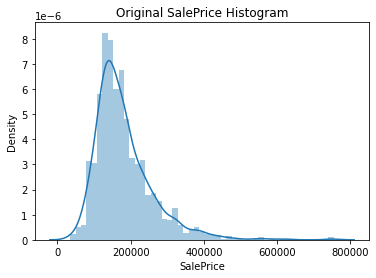

In [27]:
plt.title('Original SalePrice Histogram')
sns.distplot(house_df['SalePrice'])

**오른쪽으로 Longtale 이므로 로그변환을 해준다**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


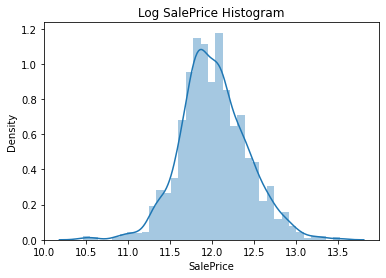

In [28]:
plt.title('Log SalePrice Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

**타겟값인 Price를 로그변환하여 정규 분포 형태로 변환하고, 피처들 중 숫자형 컬럼의 Null값 데이터 처리**

In [29]:
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

house_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

house_df.fillna(house_df.mean(), inplace=True)

null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]

In [31]:
print(house_df.dtypes[null_column_count.index])

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


One Hot Incoding 을 함과 동시에 object 컬럼들의 null값 제거

In [33]:
house_df_ohe = pd.get_dummies(house_df)
print(house_df.shape, house_df_ohe.shape)

(1460, 76) (1460, 272)


In [35]:
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print(house_df_ohe.dtypes[null_column_count.index])

Series([], dtype: object)


# 선형 회귀 모델의 학습/예측/평가

In [40]:
def get_rmse(model):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print('MODEL : {0}, 로그 변환된 RMSE : {1:.3f}'.format(model.__class__.__name__, rmse))
  return rmse

In [41]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_data = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
y_target = house_df_ohe['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3)

LR = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models = [LR, ridge, lasso]
for model in models:
  get_rmse(model)

MODEL : LinearRegression, 로그 변환된 RMSE : 0.183
MODEL : Ridge, 로그 변환된 RMSE : 0.175
MODEL : Lasso, 로그 변환된 RMSE : 0.241


**회귀 계수값과 컬럼명 시각화를 위해 상위 10개, 하위 10개(-값으로 가장 큰 10개) 회귀 계수값과 컬럼명을 가지는 Series생성 함수**

In [45]:
def get_top_bottom_coef(model):
  coef = pd.Series(model.coef_, index=X_data.columns)

  coef_top = coef.sort_values(ascending=False).head(10)
  coef_bottom = coef.sort_values(ascending=False).tail(10)
  return coef_top, coef_bottom

In [60]:
def visualize_coefficient(models):
  fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
  # fig.tight_layout()
  for i_num, model in enumerate(models):
    coef_top, coef_bottom = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_top, coef_bottom])

    axs[i_num].set_title(model.__class__.__name__)
    axs[i_num].tick_params(axis='y', pad=-100)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
        label.set_fontsize(12)
    sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

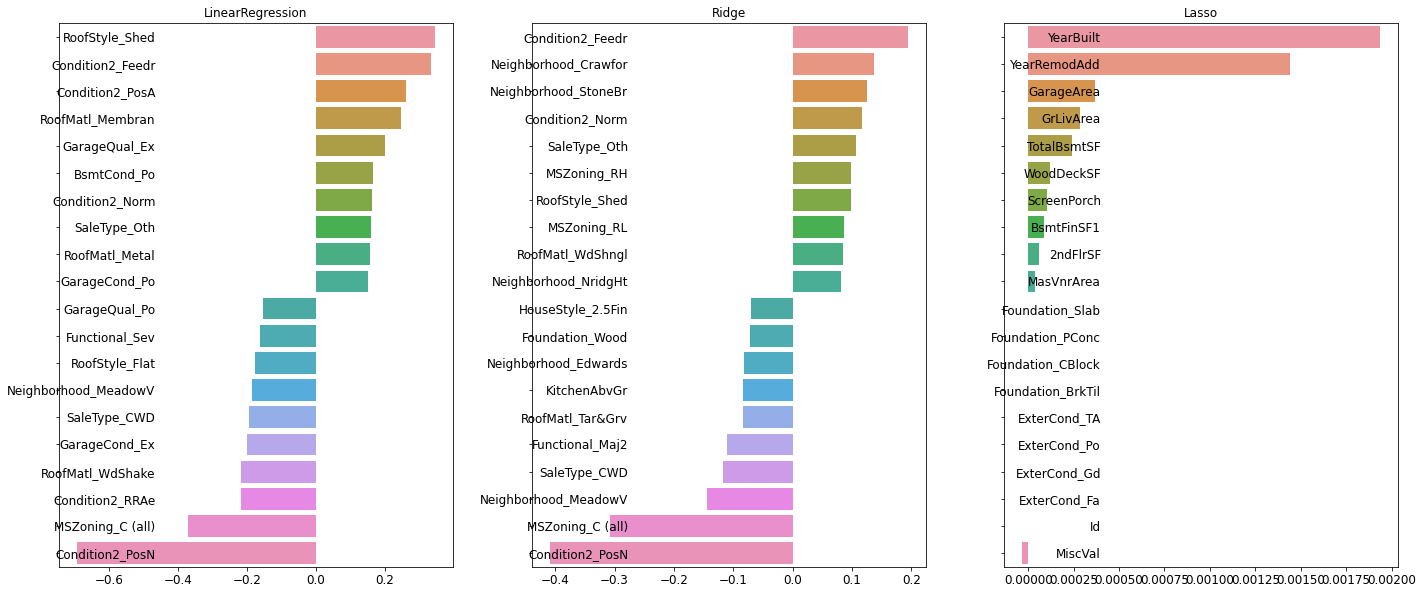

In [61]:
models = [LR, ridge, lasso]
visualize_coefficient(models)